In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = BlockRNNModel(
        model="LSTM",
        model_name=f"model_{fold+1}",
        input_chunk_length=65,
        hidden_dim=122,
        n_rnn_layers=1,
        n_epochs=100,
        batch_size=106,
        dropout=0.12887879111838008,
        add_encoders=encoders,
        output_chunk_length=1,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.SmoothL1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        optimizer_kwargs={"lr": 0.0016408452237179332, "weight_decay": 9.711713443577775e-05},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.045
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.040
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.031
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.028
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.026
Metric val_loss improved by 0.003 >= min_d

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     8.234485    2.869579    2.238345  0.835186   
Precipitation_accumulated       0.326983    0.571824    0.329809  0.494535   
Humidity                       61.277609    7.828002    5.898458  0.807865   
Wind_Speed_kmh                  0.401384    0.633548    0.512068  0.071989   
Soil_Moisture              113153.726755  336.383303  259.118088  0.822759   
Soil_Temperature               14.295858    3.780986    2.778299  0.802787   
Wind_Dir_Sin                    0.256714    0.506670    0.405727  0.199927   
Wind_Dir_Cos                    0.257422    0.507368    0.391545  0.317728   

                                SMAPE  
Temperature                 14.122974  
Precipitation_accumulated    9.669820  
Humidity                     9.343873  
Wind_Speed_kmh              51.027675  
Soil_Mo

Metric val_loss improved. New best score: 6.397
Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 6.363
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 6.354
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 6.344
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 6.336
Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 6.323
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 6.313
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 6.308
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 6.305
Monitored metric val_loss did not improve in the last 10 records. Best score: 6.305. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expe

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE         R2  \
Temperature                2.797754e+02    16.726488    14.373688  -7.463153   
Precipitation_accumulated  1.461494e+05   382.294952   332.978217  -2.952515   
Humidity                   5.344922e+02    23.119088    20.098270  -3.237293   
Wind_Speed_kmh             4.806235e+00     2.192313     1.966048 -15.318112   
Soil_Moisture              1.500149e+07  3873.176149  3370.380012  -9.791927   
Soil_Temperature           2.564089e+02    16.012774    13.745984  -6.409499   
Wind_Dir_Sin               1.599479e-01     0.399935     0.359886   0.287261   
Wind_Dir_Cos               1.539254e+00     1.240667     1.044995  -1.402583   

                                SMAPE  
Temperature                141.260195  
Precipitation_accumulated  151.543256  
Humidity                    27.944203  
Wind_Speed_kmh             14

Metric val_loss improved. New best score: 0.006
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which m

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    3.848701    1.961811    1.619185  2.503776e-01   
Precipitation_accumulated    154.205930   12.417968    9.911165 -1.504502e+06   
Humidity                      77.173825    8.784863    7.390260 -3.537771e+00   
Wind_Speed_kmh                 0.047959    0.218996    0.185282          -inf   
Soil_Moisture              15412.147976  124.145672  105.883054 -1.027896e+01   
Soil_Temperature               6.136445    2.477185    1.955600 -5.522845e-02   
Wind_Dir_Sin                   0.015758    0.125531    0.114500          -inf   
Wind_Dir_Cos                   0.010016    0.100077    0.082372          -inf   

                                SMAPE  
Temperature                 12.076466  
Precipitation_accumulated    2.128153  
Humidity                     8.785393  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    0.555383    0.745240    0.588520 -7.643792e-02   
Precipitation_accumulated    889.314748   29.821381   28.052703 -2.664899e+04   
Humidity                      17.918562    4.233032    3.394119 -7.892073e-01   
Wind_Speed_kmh                 0.025659    0.160184    0.140166          -inf   
Soil_Moisture              91613.165438  302.676668  266.598100 -2.056950e+00   
Soil_Temperature               1.591845    1.261683    1.115689 -7.266344e+00   
Wind_Dir_Sin                   0.003516    0.059298    0.056006          -inf   
Wind_Dir_Cos                   0.001858    0.043100    0.038776          -inf   

                                SMAPE  
Temperature                  6.119137  
Precipitation_accumulated    6.339501  
Humidity                     3.777880  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.005
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: Po

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    2.030405    1.424923    1.162538     0.131800   
Precipitation_accumulated    695.626996   26.374742   23.576858 -2379.464128   
Humidity                      32.940738    5.739402    4.737974     0.261464   
Wind_Speed_kmh                 0.017268    0.131407    0.099052    -7.007697   
Soil_Moisture              14399.720208  119.998834  109.091974    -0.727469   
Soil_Temperature               2.148576    1.465802    1.249380    -0.351173   
Wind_Dir_Sin                   0.024655    0.157020    0.071550     0.587498   
Wind_Dir_Cos                   0.030981    0.176014    0.080159     0.661197   

                                SMAPE  
Temperature                 16.630746  
Precipitation_accumulated    5.306472  
Humidity                     5.677492  
Wind_Speed_kmh             18

Metric val_loss improved. New best score: 0.038
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.028
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.027
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.026
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.024
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.022
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.019
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.017
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.015
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.015. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     3.433062    1.852852    1.428995    0.645264   
Precipitation_accumulated     715.737921   26.753279   21.528543 -629.533980   
Humidity                       67.571534    8.220191    7.067473    0.386390   
Wind_Speed_kmh                  0.757085    0.870106    0.649805    0.514000   
Soil_Moisture              652346.850988  807.679919  728.142556    0.428927   
Soil_Temperature                3.613164    1.900833    1.515830    0.281403   
Wind_Dir_Sin                    0.346531    0.588669    0.438546    0.297749   
Wind_Dir_Cos                    0.339720    0.582855    0.452026    0.286112   

                                SMAPE  
Temperature                 38.833941  
Precipitation_accumulated    4.830462  
Humidity                     7.775902  
Wind_Speed_kmh              8

Metric val_loss improved. New best score: 0.023
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.021
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.017
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.013
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.013. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE          R2  \
Temperature                    6.002920    2.450086   1.867884    0.776330   
Precipitation_accumulated    217.510596   14.748240  12.117469 -900.112907   
Humidity                      30.661736    5.537304   4.452186    0.792131   
Wind_Speed_kmh                 0.597697    0.773109   0.578373    0.505825   
Soil_Moisture              11309.249190  106.344954  85.687374   -0.915863   
Soil_Temperature               2.856163    1.690019   1.464389    0.740893   
Wind_Dir_Sin                   0.395291    0.628722   0.520154    0.268798   
Wind_Dir_Cos                   0.289745    0.538279   0.443054    0.123644   

                                SMAPE  
Temperature                 17.050171  
Precipitation_accumulated    2.649301  
Humidity                     5.550240  
Wind_Speed_kmh              55.475782  
Soil_Mo

In [5]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12887879111838008 and num_layers=1


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=122, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.12887879111838008, activation=ReLU, model_name=model_1, input_chunk_length=65, n_epochs=100, batch_size=106, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, output_chunk_length=1, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f9f4ea0ef90>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.0016408452237179332, 'weight_decay': 9.711713443577775e-05})

In [6]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


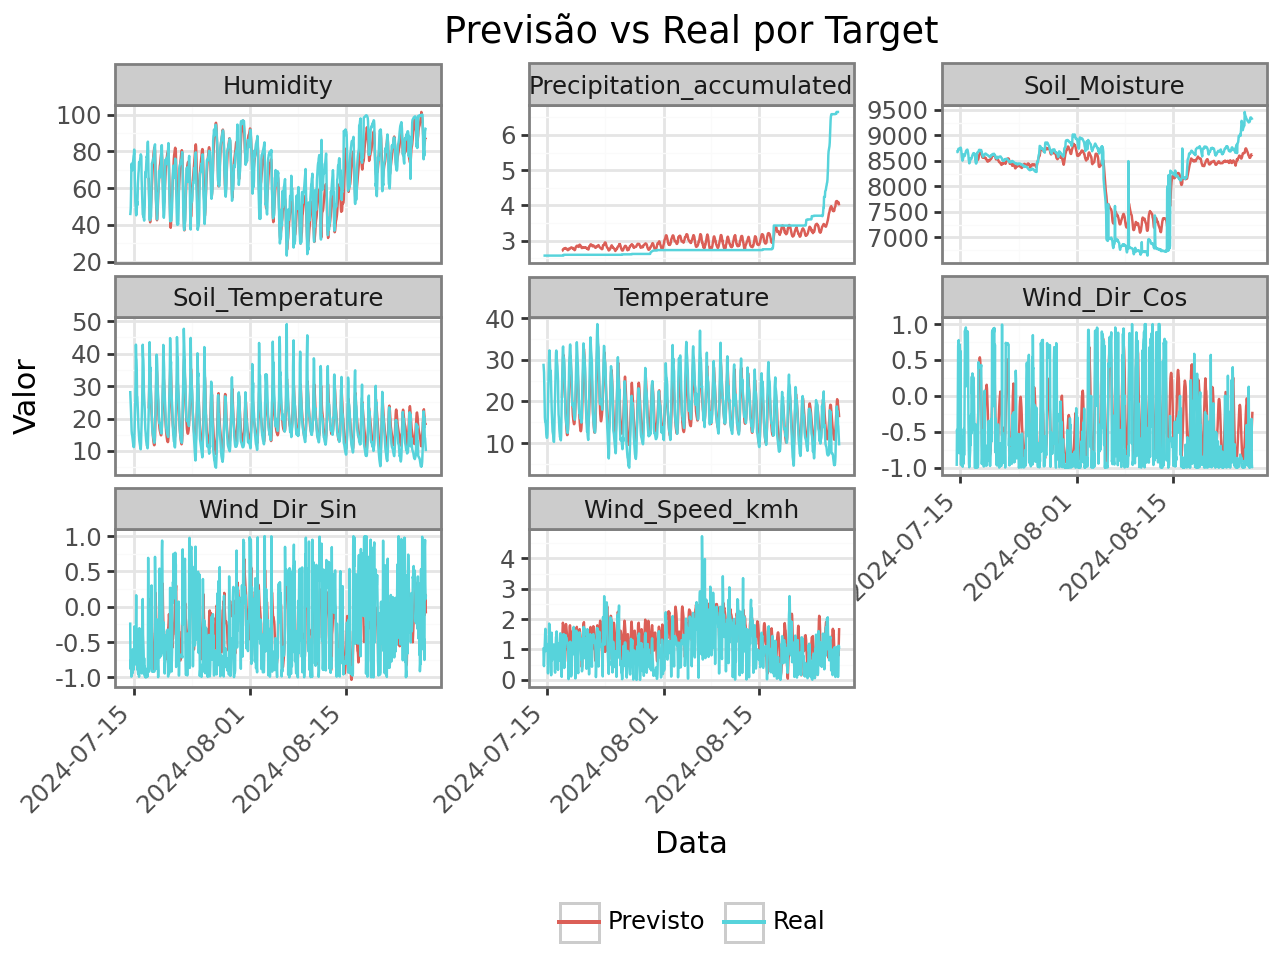

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [7]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [8]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

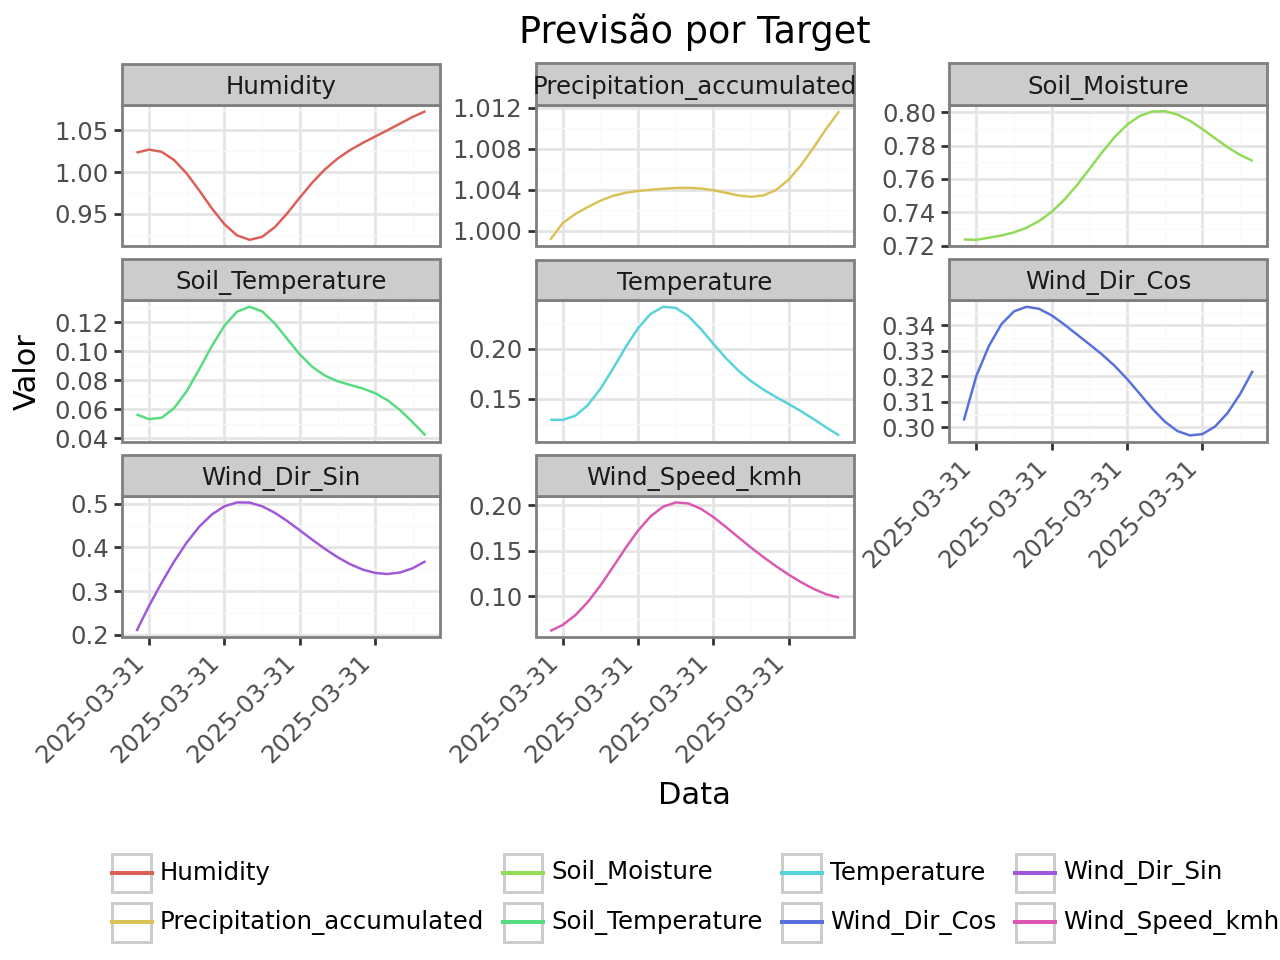

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [9]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [10]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)